# Data Science In Python
# COMP41680 Assignment 2: Text Scraping & Clustering


<b>Overview:</b>
The objective of this assignment is to scrape a corpus of news articles from a set of
web pages, pre-process the corpus, and then to apply unsupervised clustering
algorithms to explore and summarise the contents of the corpus.

## Load the text corpus generated

<b><font size="2" color="red",style="font-family:verdana;">Read all .txt docs from the current directory</font></b>


In [161]:
import os
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
corpus_root = './'
newcorpus = PlaintextCorpusReader(corpus_root, '.*')

y = newcorpus.fileids()
list_docs=[]
for item in y:
    txt=item.split('.')[1]
    if(txt == 'txt'): #only .txt documents are to be appended to the list
        list_docs.append(item)


## Data Preprocessing


In [162]:
import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
final_doc_list = []

#reading each document one by one
for i in list_docs:
    with open(i, 'r',encoding="utf8") as myfile:
        data=myfile.read()
    tokenize = CountVectorizer().build_tokenizer()
   
    # convert to lowercase, then tokenize
    tokens1 = tokenize(data.lower())
    
    #Stop word list
    from sklearn.feature_extraction import text
    stopwords = text.ENGLISH_STOP_WORDS

    #Removing stop words
    filtered_tokens1 = [word for word in tokens1 if word not in stopwords]

    #Lemmatisation using wordnet lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in filtered_tokens1:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    
    final_doc_list.append(lemma_tokens)


In [163]:
#creating a new list with each element as a string representing a document
final_doc_list2 = []
s = ""
for i in final_doc_list:
    temp = " ".join(i)
    final_doc_list2.append(temp)
    

<b><font size="2" color="red",style="font-family:verdana;">Document Term Matrix</font></b>


In [164]:
#create the document term matrix
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(final_doc_list2)
#we can print out the ros and columns in the sparce matrix generated
print(X.shape)

(1131, 19080)


<b>Observarions</b>:We see the number of rows as 1131 which represets the number of documents and 19080 columns as the totoal number of words in the corpus after preprocessing.


In [165]:
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


## Summarise the overall corpus

<b><font size="2" color="red",style="font-family:verdana;">Creating a vocabulary</font></b>


In [166]:
terms = vectorizer.get_feature_names()
vocab = vectorizer.vocabulary_
print("Vocabulary has %d distinct terms" % len(terms))
#we can print out he vocab dictionary to see the words along with their column number
#print(vocab)


Vocabulary has 19080 distinct terms


In [167]:
#we can find the column_no of ay word form the vocabulary
print("Column no is ",vocab["alcatel"])

#we can also find the word in the vocabulary give the column number
for word, column_no in vocab.items():
    if (column_no == 1355):
        print ("The word having column number:",column_no,"is ",word)


Column no is  1355
The word having column number: 1355 is  alcatel


In [168]:
#counting the total number of uniques words in the corpus
counts = {}
# process filtered tokens for each document
for doc_tokens in final_doc_list:
    for token in doc_tokens:
        # increment existing?
        if token in counts:
            counts[token] += 1
        # a new term?
        else:
            counts[token] = 1
print("Found %d unique terms in this corpus" % len(counts))
import operator
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)

#print the top 10 words with highest frequency along with their count
for i in range(10):
    term = sorted_counts[i][0]
    count = sorted_counts[i][1]
    print( "%s (count=%d)" % ( term, count )  )

Found 19089 unique terms in this corpus
said (count=3654)
year (count=2062)
cent (count=1391)
people (count=1291)
ireland (count=1046)
new (count=961)
time (count=956)
health (count=941)
mr (count=893)
game (count=892)


<b>Observations:</b>Above we see the top 10 commonly occuring words in the corpus

In [169]:
#we create a new list containing tokens from all the documents into one list
all_corpus_tokens = []
for i in final_doc_list:
    for j in i:
        all_corpus_tokens.append(j)
        

<b><font size="2" color="red",style="font-family:verdana;">Generating bigrams</font></b>


In [170]:
#we use the list created above to create bigrams and calculate the frequency
bgs = nltk.bigrams(all_corpus_tokens)
fdist = nltk.FreqDist(bgs)

#we then sort the bigrams created based on frequency to get the top 10 frequent bigrams
fdist_new = list(fdist.items())
fdist_new.sort(key=lambda item: item[-1], reverse=True)
print(fdist_new[0:10])

[(('closed', 'article'), 551), (('comment', 'closed'), 501), (('return', 'result'), 475), (('online', 'news'), 338), (('said', 'mr'), 203), (('chief', 'executive'), 196), (('euro', 'zone'), 158), (('report', 'content'), 147), (('good', 'faith'), 147), (('faith', 'believe'), 146)]


<b>Observations:</b> Above we see the top 10 frequent bigrams or phrases of size 2 in the corpus along with their frequency

<b><font size="2" color="red",style="font-family:verdana;">Generating a TfIdf Matrix</font></b>


In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer2 = TfidfVectorizer()
Y = vectorizer2.fit_transform(final_doc_list2)
indices = np.argsort(vectorizer2.idf_)[::-1]
features = vectorizer2.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

#converting the csr_sparce matrix to a numpy array to use later
y1 = Y.toarray()


['šemeta', 'incurable', 'incubator', 'incresae', 'incredulous', 'incredulity', 'incredibly', 'increasespeaking', 'increasesbut', 'increaseminister']


In [172]:
print(Y.shape)

(1131, 19080)


## Applying Clustering Algorithms and Summarization 

<b><font size="2" color="red",style="font-family:verdana;">Function for plotting clusters</font></b>


In [173]:
#plotting clusters using PCA and and t-SNE from scikit-learn.
#http://stackoverflow.com/questions/27494202/how-do-i-visualize-data-points-of-tf-idf-vectors-for-kmeans-clustering?rq=1

def plotting(cluster_final):

    from sklearn.cluster import KMeans
    from sklearn.manifold import TSNE

    labels = cluster_final

    from sklearn.decomposition import PCA

    pca = PCA(n_components=2).fit(y1)
    pca_coords = pca.transform(y1)

    #creating a list of custom colors
    label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#e9df29", "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
    colors = [label_colors[i] for i in labels]
    
    #decribing plot size
    plt.figure(figsize=(6,6))
    #scatter plot for showing clusters
    plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=colors,s=25)
    plt.show()

    tsne_num_components = 2

    # t-SNE plot
    embeddings = TSNE(n_components=tsne_num_components)
    Z = embeddings.fit_transform(y1)
    plt.scatter(Z[:, 0], Z[:, 1], c = colors,cmap=plt.cm.Spectral)
    plt.show()

<b><font size="2" color="red",style="font-family:verdana;">Cluster Analysis</font></b><br>
In this we will obtain the top 10 most characteristic words from the whole corpus based on their TF-IDF scores and then assign a title for each cluster

In [178]:
#function for grouping the docs based on the clustering algorithm output and then performing tfidf on thses groups to get insights
def analyze(big_list):
    import nltk
    l2=[]
    for j in range(1131): #loop over the total number of docs in the corpus
        list1=[]
        for i in range(10): #range is 10 as the clustering algorithm were run 10 times for better accuracy
            list1.append(big_list[i][j])
        l2.append(list1)
    cluster_final=[]
    for item in l2:
        freq_dist = nltk.FreqDist(item) # creates a frequency distribution from a list
        most_common = freq_dist.max()    # returns a single element
        cluster_final.append(most_common) #in this list each element has the cluster number for each document at that index
    
    plotting(cluster_final) #calling the plotting function by passing the updated clsuter output list
    
    #creating 4 groups for 4 clusters
    #saving the index w.r.t clusters no 
    docs_cluster_0_indices = [i for i, x in enumerate(cluster_final) if x == 0]
    docs_cluster_1_indices = [i for i, x in enumerate(cluster_final) if x == 1]
    docs_cluster_2_indices = [i for i, x in enumerate(cluster_final) if x == 2]
    docs_cluster_3_indices = [i for i, x in enumerate(cluster_final) if x == 3]
    
    cluster_0_list = []
    cluster_1_list = []
    cluster_2_list = []
    cluster_3_list = []

    #getting the actual docs in the groups by index from our main corpus list final_doc_list2
    #each of these lists will contain docs corresponding to the clusters 0,1,2,3
    for i in docs_cluster_0_indices:
        cluster_0_list.append(final_doc_list2[i])
    for i in docs_cluster_1_indices:
        cluster_1_list.append(final_doc_list2[i])
    for i in docs_cluster_2_indices:
        cluster_2_list.append(final_doc_list2[i])
    for i in docs_cluster_3_indices:
        cluster_3_list.append(final_doc_list2[i])
    
        
    #performing tfidf on these 4 groups
    from sklearn.feature_extraction.text import TfidfVectorizer
    import numpy as np
    from operator import itemgetter

    vectorizer2 = TfidfVectorizer(stop_words="english",min_df = 3, max_df = 8,ngram_range = (1,2))#, token_pattern = '/^([^0-9]*)$/')

    #cluster0
    C1 = vectorizer2.fit_transform(cluster_0_list)
    names=vectorizer2.get_feature_names()
    # Obtaining highest tfidf value and corresponding document number of Each Word
    max_idf_by_word=[(C1.getcol(i).A.max(),C1.getcol(i).A.argmax(),names[i]) for i in range(C1.shape[1])]
    # Fetching top 10 TF-IDF valued names from the list of tuples
    most_characteristic=[name for _,__,name in sorted(max_idf_by_word,key=itemgetter(0))[::-1][:10]]
    print("Top Characteristics words in Cluster 0")
    print(most_characteristic)

    #cluster1
    C2 = vectorizer2.fit_transform(cluster_1_list)
    names=vectorizer2.get_feature_names()
    max_idf_by_word=[(C2.getcol(i).A.max(),C2.getcol(i).A.argmax(),names[i]) for i in range(C2.shape[1])]
    # Fetching top 10 TF-IDF valued names from the list of tuples
    most_characteristic=[name for _,__,name in sorted(max_idf_by_word,key=itemgetter(0))[::-1][:10]]
    print("Top Characteristics words in Cluster 1")
    print(most_characteristic)

    #cluster2
    C3 = vectorizer2.fit_transform(cluster_2_list)
    names=vectorizer2.get_feature_names()
    max_idf_by_word=[(C3.getcol(i).A.max(),C3.getcol(i).A.argmax(),names[i]) for i in range(C3.shape[1])]
    # Fetching top 10 TF-IDF valued names from the list of tuples
    most_characteristic=[name for _,__,name in sorted(max_idf_by_word,key=itemgetter(0))[::-1][:10]]
    print("Top Characteristics words in Cluster 2")
    print(most_characteristic)

    #cluster3
    C4 = vectorizer2.fit_transform(cluster_3_list)
    names=vectorizer2.get_feature_names()
    max_idf_by_word=[(C4.getcol(i).A.max(),C4.getcol(i).A.argmax(),names[i]) for i in range(C4.shape[1])]
    # Fetching top 10 TF-IDF valued names from the list of tuples
    most_characteristic=[name for _,__,name in sorted(max_idf_by_word,key=itemgetter(0))[::-1][:10]]
    print("Top Characteristics words in Cluster 3")
    print(most_characteristic)

<b><font size="2" color="red",style="font-family:verdana;">KMeans Algorithm</font></b>

<i>Note: Runtime for executing the cell below requires approx 5 mins.</i>

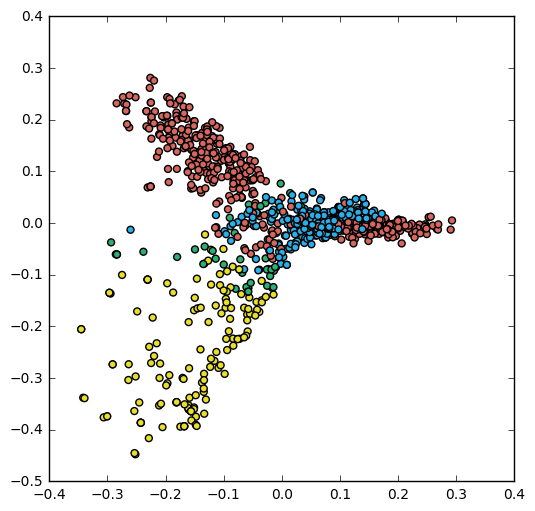

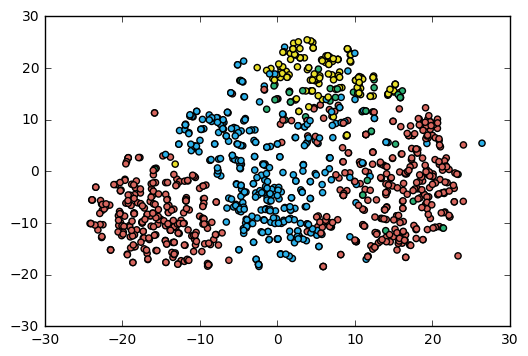

Top Characteristics words in Cluster 0
['cancer', 'patent', 'robot', 'commodore', 'suicide', 'domain', 'food', 'musician', 'virgin', 'alcatel']
Top Characteristics words in Cluster 1
['republic', 'cancer', 'claim', 'clinic', 'nurse', 'stock', 'young', 'tobacco', 'symptom', 'waiting']
Top Characteristics words in Cluster 2
['survival', 'robson', 'transplant', 'gay', 'edu', 'breast', 'houllier', 'leeds', 'nama', 'bellamy']
Top Characteristics words in Cluster 3
['alcohol', 'waiting', 'accident', 'incident', 'hand', 'built', 'gp care', 'mental health', 'caesarean section', 'caesarean']


In [179]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

big_list = []
# find 4 clusters
for i in range(10): #running the algorithm 10 times
    model = KMeans(4)  
    model.fit(y1) #passing the numpy array of tfidf sparce matrix Y
    clustering = model.labels_
    big_list.append(clustering)
    
analyze(big_list) #calling the function for analysis on the clustering output


<b>Observations:</b>As we can see above , we get the 10 most characteristic words for each cluster.<br>
So,<br>for Cluster 0 we can give the title :-<b>Technology</b>, as we have words like 'alcatel','domain','virgin','commodore'<br>
for Cluster 1 we can give the title :-<b>Health</b>, as we words like 'cancer','nurse','clinic','sympton','tobacco'<br>
for Cluster 2 we can give the title :-<b>Football/Sports</b>, as we have words like 'houllier','bellamy','robson','leeds' which are realted to football<br>
for Cluster 3 we can give the title :-<b>Health/Medical</b>, as we have words like 'mental health','caesarean section','accident'<br>

<b><font size="2" color="red",style="font-family:verdana;">Agglomerative clustering Algorithm</font></b>

<i>Note: Runtime for executing the cell below requires approx 5 mins.</i>

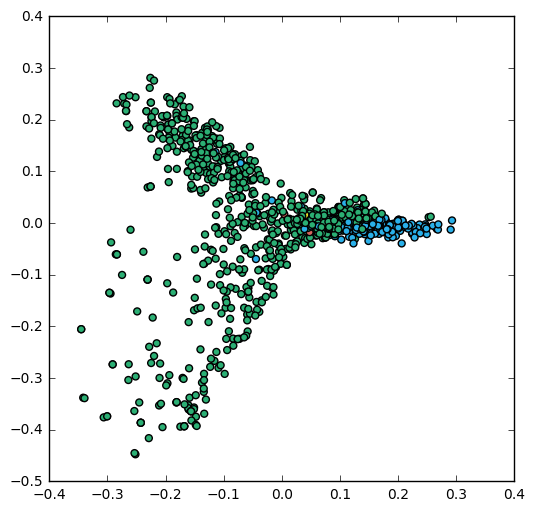

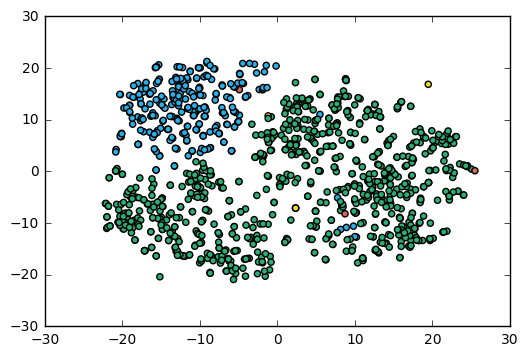

Top Characteristics words in Cluster 0
['robson', 'christmas', 'edu', 'mutu', 'bellamy', 'barwick', 'juninho', 'hamm', 'houllier', 'leeds']
Top Characteristics words in Cluster 1
['robot', 'domain', 'commodore', 'musician', 'young woman', 'onset', 'alcatel', 'breast cancer', 'virgin', 'dementia']
Top Characteristics words in Cluster 2
['news']
Top Characteristics words in Cluster 3
['sport', 'say', 'wall', 'kilkenomics', 'festival', 'discussion', 'economist', 'dr', 'irish', 'photograph']


In [180]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

big_list = []
# find 4 clusters
for i in range(10):
    #cut at 4 clusters
    model = AgglomerativeClustering(n_clusters=4,affinity="euclidean",linkage="average")
    model.fit(y1) #passing the numpy array of tfidf sparce matrix Y
    # get the flat clustering
    clustering = model.labels_
    big_list.append(clustering)
    
analyze(big_list) #calling the function for analysis on the clustering output


<b>Observations:</b>As we can see above , we get the 10 most characteristic words for each cluster.<br>
So,<br>for Cluster 0 we can give the title :-<b>Football/Sports</b><br>
for Cluster 1 we can give the title :-<b>Technology</b><br>
for Cluster 2 we can give the title :-<b>News</b><br>
for Cluster 3 we can give the title :-<b>Festivals/Lifestyle</b><br>

# Conclusion
We observe that the clustering algorithms produce different output on different runs this is due to randomized initialization of these algorithms.Both the clustering algorithms produced different clustering results. The Kmeans algorithm was able to produce quite distinct clusters, however the agglomerative algorithm is able to show two clusters clearly yet the other two clusters were not distinctively formed.In the end we were able to provide titles to the cluster groups.